<a href="https://colab.research.google.com/github/VinhDevNguyen/Machine-Learning/blob/master/Project/Audio_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [ ]:
! mkdir genres

In [ ]:
! tar -xvzf genres.tar.gz 

# Preprocessing audio data for Deep Learning

### Import module

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

### Waveform

In [ ]:
file = "/content/drive/My Drive/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"

In [ ]:
signal, sr = librosa.load(file,) # sr * T -> 22050 *30
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### fft -> spectrum

In [ ]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### stft -> Spectrogram

In [ ]:
n_fft = 2048
hop_lengt = n_fft / 4

In [ ]:
stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=int(hop_lengt))
stft

In [ ]:
spectrogram = abs(stft)

In [ ]:
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [ ]:
log_spectrogram = librosa.core.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs

In [ ]:
MFFCs = librosa.feature.mfcc(signal)

In [ ]:
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

# Preparing the dataset

In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/My Drive/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13 
n_fft=2048
hop_length=512
num_segments=5

# dictionary to store mapping, labels, and MFCCs
data = {
"mapping": [],
"labels": [],
"mfcc": []
}

samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

# loop through all genre sub-folder
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
  # ensure we're processing a genre sub-folder level
  if dirpath is not DATASET_PATH:
    # save genre label (i.e., sub-folder name) in the mapping
    semantic_label = dirpath.split("/")[-1]
    data["mapping"].append(semantic_label)
    print("\nProcessing: {}".format(semantic_label))

    # process all audio files in genre sub-dir
    for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        print(file_path)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
                data["mfcc"].append(mfcc.tolist())
                data["labels"].append(i-1)
                print("segment:{}".format(d+1))

# save MFCCs to json file
with open(JSON_PATH, "w") as fp:
  json.dump(data, fp, indent=4)


# Neuron network for audio

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

## Load data

In [2]:
with open("/content/drive/My Drive/genres/data_10.json", "r") as fp:
  data = json.load(fp)

In [3]:
X = np.array(data["mfcc"])
y = np.array(data["labels"])

## Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Create model

In [5]:
model = keras.Sequential([
  # Input layer
  keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
  # Hiden layers
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dense(64, activation="relu"),
  # Output layer
  keras.layers.Dense(10, activation="softmax")
])

Compile network

In [6]:
optimizer = keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3367)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1724416   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,872,842
Trainable params: 1,872,842
Non-trainable params: 0
_________________________________________________________________


Train network

In [7]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=32,
          )

Epoch 1/100
110/110 [==============================] - 1s 8ms/step - loss: 10.4183 - accuracy: 0.2876 - val_loss: 5.0336 - val_accuracy: 0.3320
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 3.7381 - accuracy: 0.3928 - val_loss: 3.9446 - val_accuracy: 0.3673
Epoch 3/100
110/110 [==============================] - 1s 6ms/step - loss: 2.5044 - accuracy: 0.4720 - val_loss: 3.5003 - val_accuracy: 0.3967
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 1.8493 - accuracy: 0.5475 - val_loss: 3.1570 - val_accuracy: 0.4200
Epoch 5/100
110/110 [==============================] - 1s 6ms/step - loss: 1.4757 - accuracy: 0.6095 - val_loss: 3.0894 - val_accuracy: 0.4167
Epoch 6/100
110/110 [==============================] - 1s 6ms/step - loss: 1.1120 - accuracy: 0.6772 - val_loss: 2.9108 - val_accuracy: 0.4267
Epoch 7/100
110/110 [==============================] - 1s 6ms/step - loss: 0.9667 - accuracy: 0.7078 - val_loss: 2.9678 - val_accuracy: 0.454

# Solving Overfitting

## Plot history

Text(0.5, 1.0, 'Error eval')

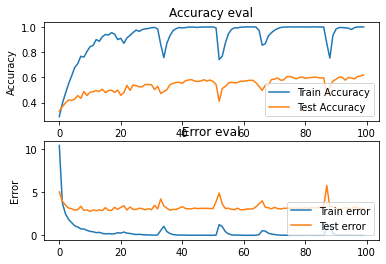

In [21]:
import matplotlib.pyplot as plt
# Create 2 empty subplots
fig, axs = plt.subplots(2)
# Create accuracy subplot
axs[0].plot(history.history["accuracy"], label="Train Accuracy")
axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# Create error subplot
axs[1].plot(history.history["loss"], label="Train error")
axs[1].plot(history.history["val_loss"], label="Test error")
axs[1].set_ylabel("Error")
axs[1].legend(loc="lower right")
axs[1].set_title("Error eval")